In [358]:
import numpy as np
import random
import json
import csv

from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing import image
from keras import optimizers
from livelossplot import PlotLossesKeras
from keras_sequential_ascii import keras2ascii
import os
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from tensorflow.keras import datasets
from sklearn.model_selection import train_test_split

In [359]:
import seaborn as sn
sn.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams.update({'font.size': 12})

In [360]:
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

In [361]:
print('Train: ',X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (60000, 28, 28) (60000,)
Test:  (10000, 28, 28) (10000,)


In [362]:
def plot_examples(X, y):
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    for i,j in enumerate(np.random.randint(0, len(X), 3)):
        ax[i].imshow(X[j], 'binary')
        ax[i].set_title(str(y[j]))
    plt.show()

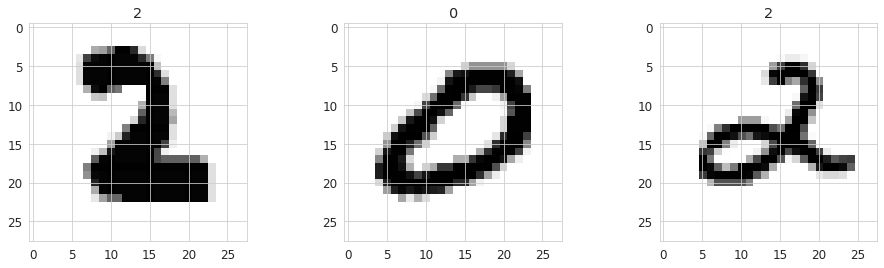

In [363]:
plot_examples(X_train, y_train)

In [364]:
def generate_data(X, y, numbers_gen=3):
    x_train_gen, y_train_gen = [], []
    for _ in range(len(X)):
        shape_gen_image = np.zeros((X.shape[1], X.shape[2] * numbers_gen))
        count_numbers = np.random.randint(1, numbers_gen + 1)
        offset = np.random.randint(0, numbers_gen - count_numbers + 1)
        labels = [10] * numbers_gen
        for i in range(offset, offset + count_numbers):
            ind = random.randint(0, X.shape[0] - 1)
            rand_digit = X[ind]
            shape_gen_image[:, i * X.shape[2]: i * X.shape[2] + X.shape[2]] = rand_digit
            labels[i] = y[ind]
        x_train_gen.append(shape_gen_image)
        y_train_gen.append(labels)
    
    return np.array(x_train_gen), np.array(y_train_gen)

In [365]:
x_train_gen, y_train_gen = generate_data(X_train, y_train)
x_test_gen, y_test_gen = generate_data(X_test, y_test)

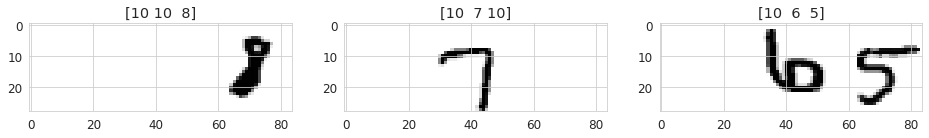

In [366]:
plot_examples(x_train_gen, y_train_gen)

Далее построим модель описанную в этой статье: http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf

*Our best architecture consists of eight convolutional hidden layers, one locally connected hidden
layer, and two densely connected hidden layers. All connections are feedforward and go from one
layer to the next (no skip connections). The first hidden layer contains maxout units (Goodfellow
et al., 2013) (with three filters per unit) while the others contain rectifier units (Jarrett et al., 2009;
Glorot et al., 2011). The number of units at each spatial location in each layer is [48, 64, 128,
160] for the first four layers and 192 for all other locally connected layers. The fully connected
layers contain 3,072 units each. Each convolutional layer includes max pooling and subtractive
normalization. The max pooling window size is 2 × 2. The stride alternates between 2 and 1 at each
layer, so that half of the layers don’t reduce the spatial size of the representation. All convolutions
use zero padding on the input to preserve representation size. The subtractive normalization operates
on 3x3 windows and preserves representation size. All convolution kernels were of size 5 × 5. We
trained with dropout applied to all hidden layers but not the input.*

In [367]:
from tensorflow import keras
from tensorflow.keras import layers, datasets

In [368]:
RESOLUTION = 28
CLASSES = 11
NUMBERS_GEN = 3
BATCH_SIZE = 128
EPOCHS = 5
INPUT_SHAPE = (RESOLUTION, RESOLUTION * NUMBERS_GEN, 1)

In [369]:
X_train, X_val, y_train, y_val = train_test_split(x_train_gen, y_train_gen, test_size=0.25)

In [370]:
X_train = X_train.reshape(-1, RESOLUTION, RESOLUTION*NUMBERS_GEN, 1)
y_train = [y_train.T[i] for i in range(NUMBERS_GEN)]

In [371]:
X_val = X_val.reshape(-1, RESOLUTION, RESOLUTION*NUMBERS_GEN, 1)
y_val = [y_val.T[i] for i in range(NUMBERS_GEN)]

In [372]:
X_test = x_test_gen.reshape(-1, RESOLUTION, RESOLUTION*NUMBERS_GEN, 1)
y_test = [y_test_gen.T[i] for i in range(NUMBERS_GEN)]

In [373]:
print('Train: ',X_train.shape, len(y_train))
print('Validation: ', X_val.shape, len(y_val))
print('Test: ', X_test.shape, len(y_test))

Train:  (45000, 28, 84, 1) 3
Validation:  (15000, 28, 84, 1) 3
Test:  (10000, 28, 84, 1) 3


In [374]:
inputs = keras.Input(INPUT_SHAPE)

x = layers.BatchNormalization()(inputs)
x = layers.Conv2D(48, 5, activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.1)(x)

x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 5, activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1))(x)
x = layers.Dropout(0.1)(x)

x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 5, activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)

x = layers.BatchNormalization()(x)
x = layers.Conv2D(160, 5, activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1))(x)
x = layers.Dropout(0.25)(x)

x = layers.BatchNormalization()(x)
x = layers.Conv2D(192, 5, activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.5)(x)

x = layers.BatchNormalization()(x)
x = layers.Conv2D(192, 5, activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1))(x)
x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)

outputs = []
for i in range(NUMBERS_GEN):
    outputs.append(layers.Dense(CLASSES, activation='softmax')(x))

model = keras.Model(inputs=inputs, outputs=outputs)
    
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 84, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 28, 84, 1)    4           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 28, 84, 48)   1248        batch_normalization_24[0][0]     
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 14, 42, 48)   0           conv2d_24[0][0]                  
____________________________________________________________________________________________

In [375]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val),
                    verbose=1)

Train on 45000 samples, validate on 15000 samples
Epoch 1/5
45000/45000 [==============================] - 503s 11ms/sample - loss: 1.5417 - dense_22_loss: 0.4911 - dense_23_loss: 0.5355 - dense_24_loss: 0.5136 - dense_22_acc: 0.8308 - dense_23_acc: 0.8075 - dense_24_acc: 0.8215 - val_loss: 2.8214 - val_dense_22_loss: 0.9151 - val_dense_23_loss: 1.0333 - val_dense_24_loss: 0.8731 - val_dense_22_acc: 0.7839 - val_dense_23_acc: 0.7387 - val_dense_24_acc: 0.7953
Epoch 2/5
45000/45000 [==============================] - 498s 11ms/sample - loss: 0.1702 - dense_22_loss: 0.0563 - dense_23_loss: 0.0565 - dense_24_loss: 0.0571 - dense_22_acc: 0.9846 - dense_23_acc: 0.9843 - dense_24_acc: 0.9845 - val_loss: 0.1426 - val_dense_22_loss: 0.0447 - val_dense_23_loss: 0.0546 - val_dense_24_loss: 0.0435 - val_dense_22_acc: 0.9891 - val_dense_23_acc: 0.9850 - val_dense_24_acc: 0.9889
Epoch 3/5
45000/45000 [==============================] - 471s 10ms/sample - loss: 0.1051 - dense_22_loss: 0.0329 - dense_2

In [376]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 37s 4ms/sample - loss: 0.1421 - dense_22_loss: 0.0479 - dense_23_loss: 0.0515 - dense_24_loss: 0.0425 - dense_22_acc: 0.9923 - dense_23_acc: 0.9896 - dense_24_acc: 0.9925


[0.14210880066910758,
 0.04789872,
 0.05145028,
 0.04253537,
 0.9923,
 0.9896,
 0.9925]

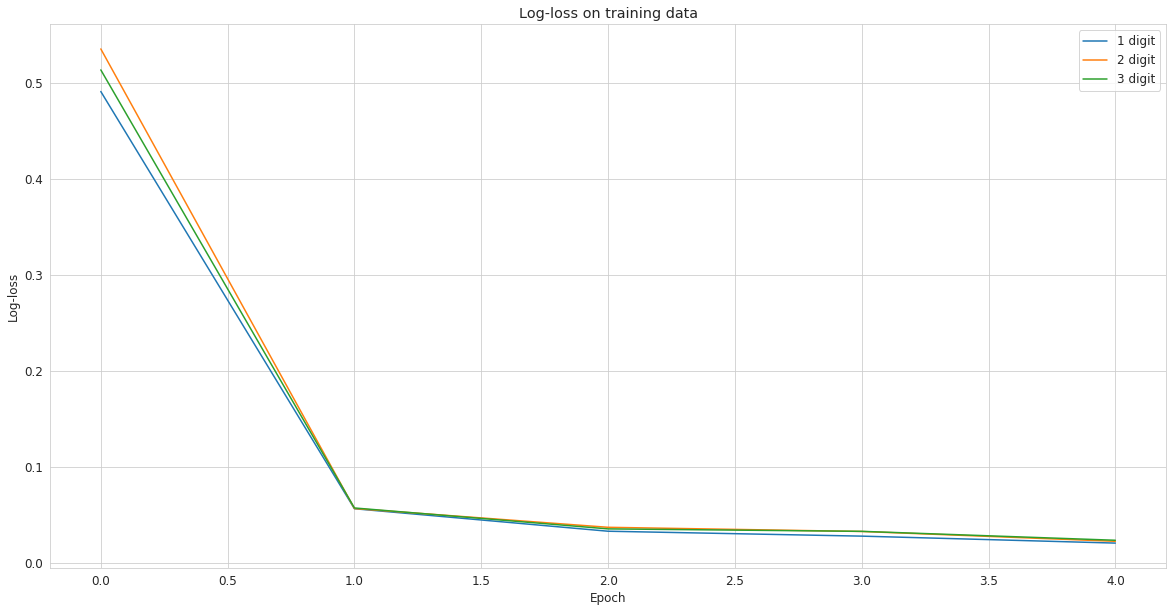

In [380]:
plt.plot(history.history['dense_22_loss'], label='1 digit')
plt.plot(history.history['dense_23_loss'], label='2 digit')
plt.plot(history.history['dense_24_loss'], label='3 digit')
plt.title('Log-loss on training data')
plt.xlabel('Epoch')
plt.ylabel('Log-loss')
plt.legend()
plt.show()

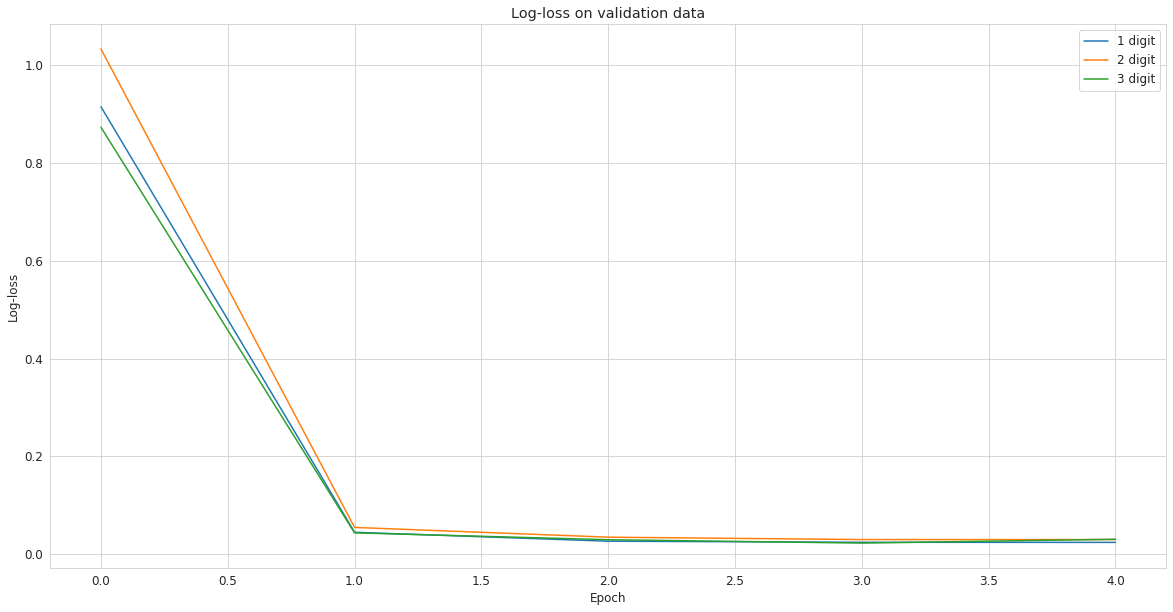

In [381]:
plt.plot(history.history['val_dense_22_loss'], label='1 digit')
plt.plot(history.history['val_dense_23_loss'], label='2 digit')
plt.plot(history.history['val_dense_24_loss'], label='3 digit')
plt.title('Log-loss on validation data')
plt.xlabel('Epoch')
plt.ylabel('Log-loss')
plt.legend()
plt.show()

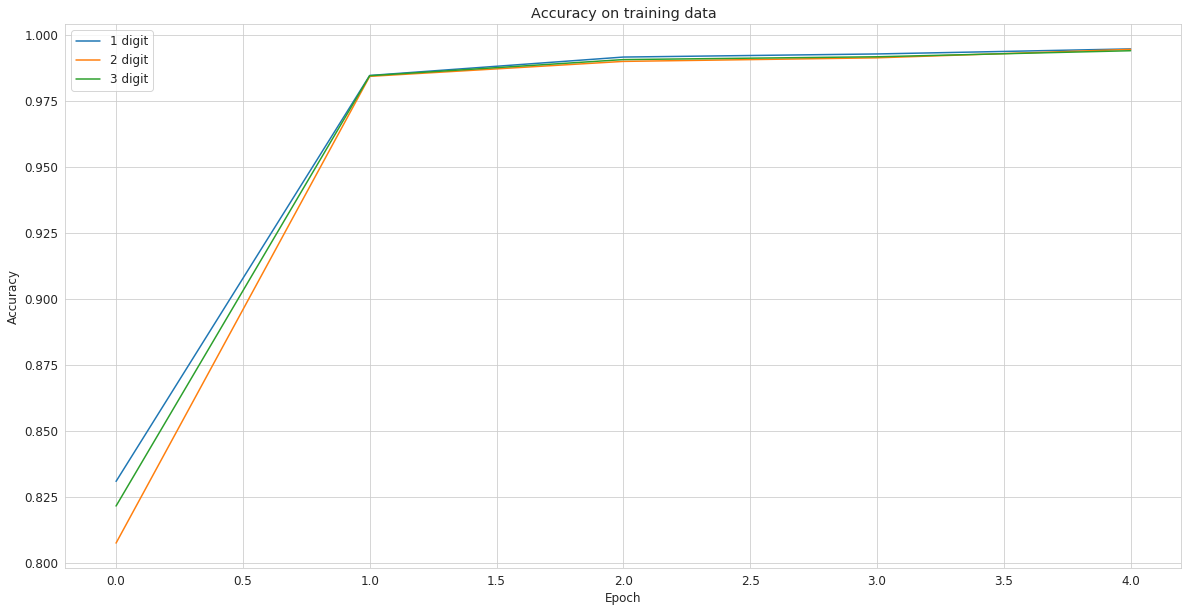

In [383]:
plt.plot(history.history['dense_22_acc'], label='1 digit')
plt.plot(history.history['dense_23_acc'], label='2 digit')
plt.plot(history.history['dense_24_acc'], label='3 digit')
plt.title('Accuracy on training data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

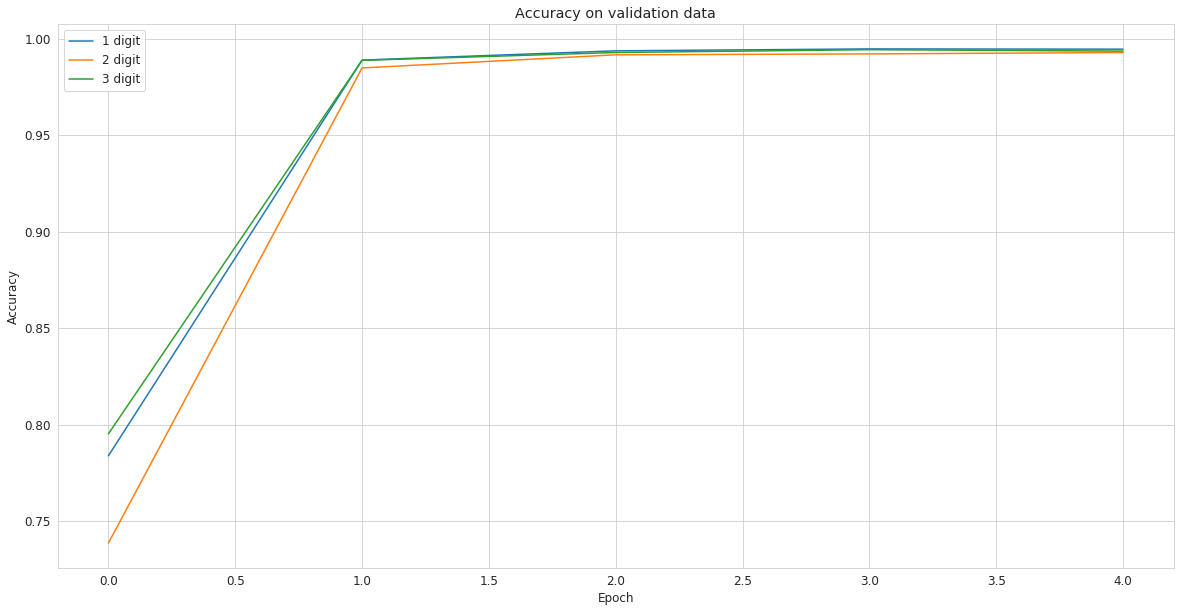

In [382]:
plt.plot(history.history['val_dense_22_acc'], label='1 digit')
plt.plot(history.history['val_dense_23_acc'], label='2 digit')
plt.plot(history.history['val_dense_24_acc'], label='3 digit')
plt.title('Accuracy on validation data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [119]:
def check_model(x_test_gen, model):
    for _ in range(5):
        test_image = random.choice(x_test_gen)
        prediction = model.predict(test_image.reshape(1,RESOLUTION,RESOLUTION*NUMBERS_GEN,1))
        print(f"Prediction: {[np.argmax(i) for i in prediction]}")
        plt.imshow(test_image, cmap='binary')
        plt.show()

Prediction: [9, 3, 10]


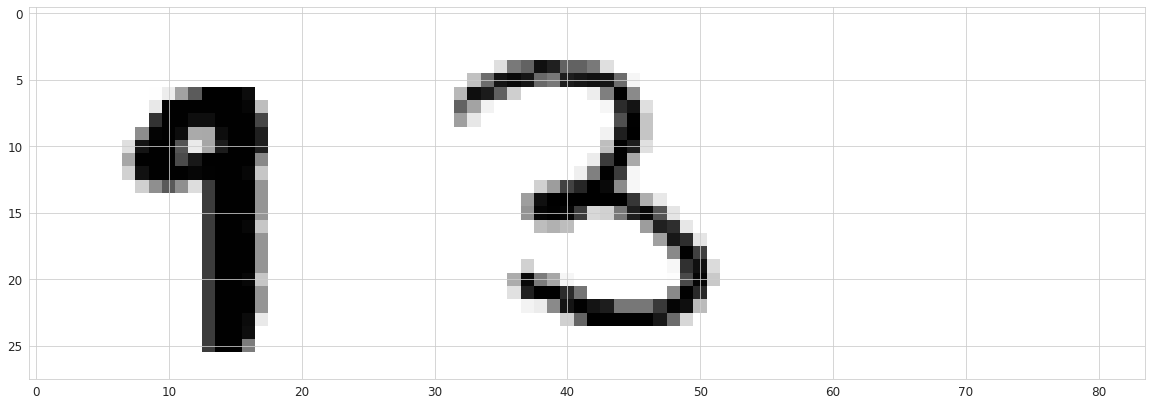

Prediction: [4, 1, 10]


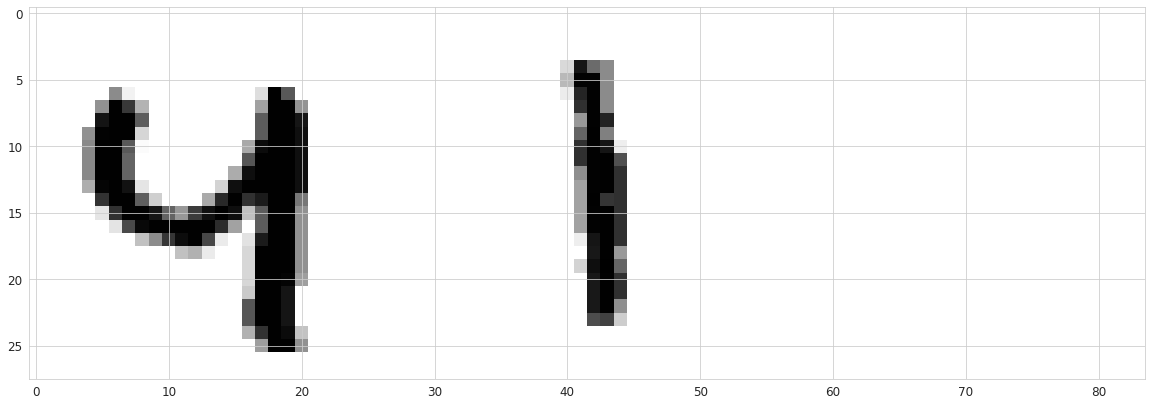

Prediction: [10, 6, 5]


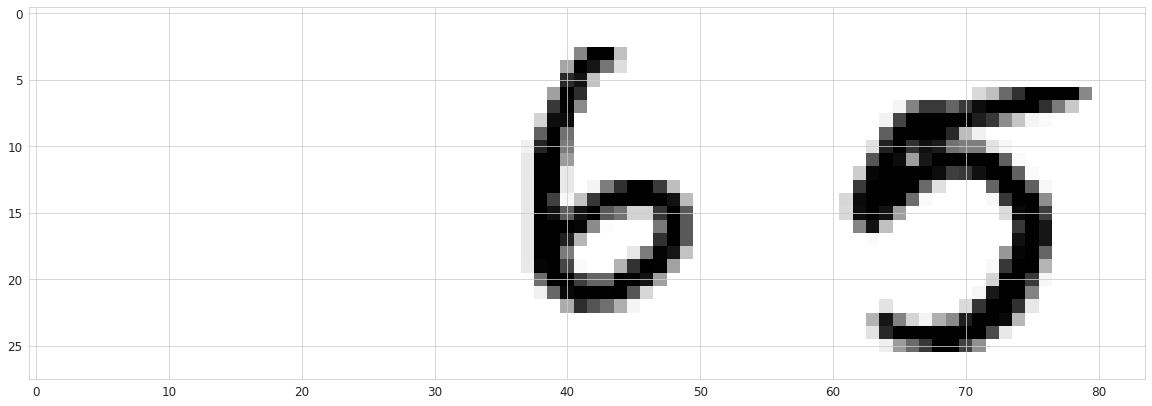

Prediction: [10, 4, 9]


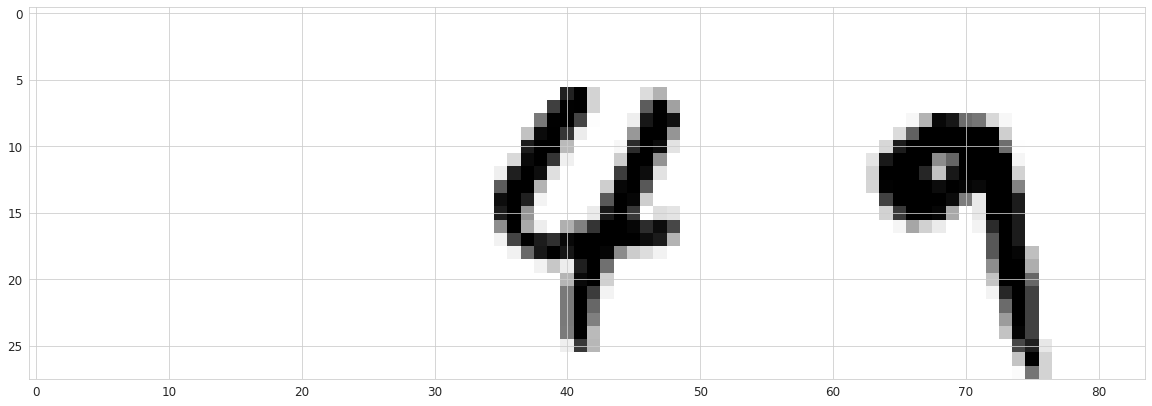

Prediction: [4, 6, 0]


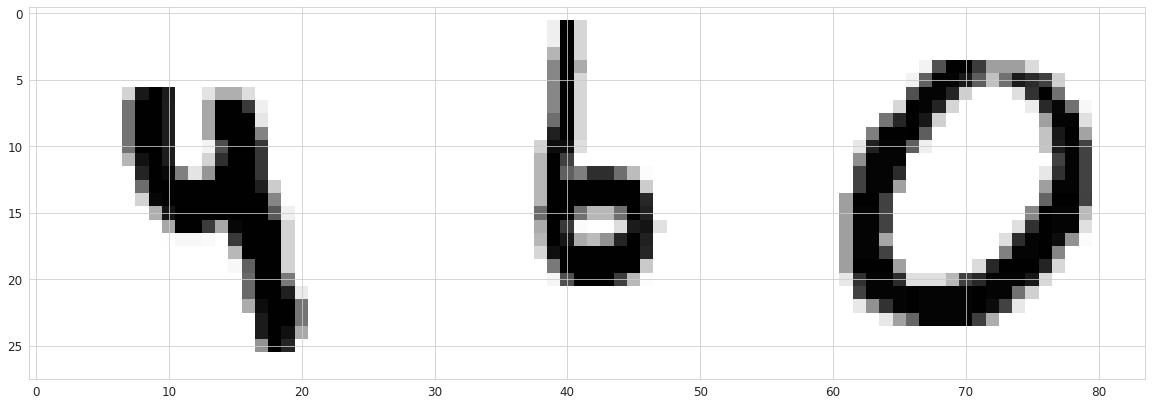

In [122]:
check_model(x_test_gen, model)

In [454]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import tensorflow as tf
from IPython.display import display, Image
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import h5py
import os

In [455]:
train_dir = 'train'
test_dir = 'test'

In [456]:
import matplotlib.image as im

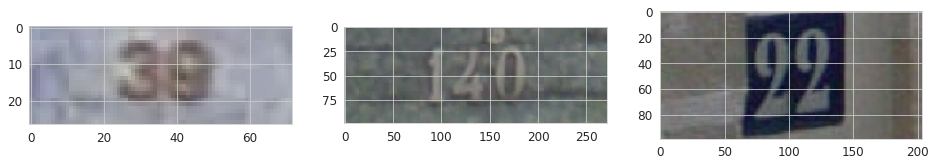

In [457]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

for i, j in enumerate(np.random.randint(1, len(os.listdir(train_dir)) - 3, 3)):
    img = im.imread(train_dir+f'/{j}.png')
    ax[i].imshow(img)

In [458]:
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label']  = pictDat[i]['label'][j]
                figure['left']   = pictDat[i]['left'][j]
                figure['top']    = pictDat[i]['top'][j]
                figure['width']  = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [459]:
structure_file = DigitStructFile(train_dir+'/digitStruct.mat')
train_data = structure_file.getAllDigitStructure_ByDigit()

/home/aksel/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [460]:
structure_file = DigitStructFile(test_dir+'/digitStruct.mat')
test_data = structure_file.getAllDigitStructure_ByDigit()

In [461]:
train_data[0]

{'filename': '1.png',
 'boxes': [{'height': 219.0,
   'label': 1.0,
   'left': 246.0,
   'top': 77.0,
   'width': 81.0},
  {'height': 219.0, 'label': 9.0, 'left': 323.0, 'top': 81.0, 'width': 96.0}]}

In [462]:
RESOLUTION = 28
NUMBERS_GEN = 3

In [463]:
import PIL.Image as Image

def generate_dataset(data, folder):
    dataset = np.ndarray([len(data),RESOLUTION, RESOLUTION,1], dtype='float32')
    labels = np.ones([len(data), 6], dtype=int) * 10
    for i in np.arange(len(data)):
        filename = data[i]['filename']
        fullname = os.path.join(folder, filename)
        im = Image.open(fullname)
        boxes = data[i]['boxes']
        num_digit = len(boxes)
        labels[i,0] = num_digit
        top = np.ndarray([num_digit], dtype='float32')
        left = np.ndarray([num_digit], dtype='float32')
        height = np.ndarray([num_digit], dtype='float32')
        width = np.ndarray([num_digit], dtype='float32')
        for j in np.arange(num_digit):
            if j < 5: 
                labels[i,j+1] = boxes[j]['label']
                if boxes[j]['label'] == 10:
                    labels[i,j+1] = 0
            top[j] = boxes[j]['top']
            left[j] = boxes[j]['left']
            height[j] = boxes[j]['height']
            width[j] = boxes[j]['width']
        
        im_top = np.amin(top)
        im_left = np.amin(left)
        im_height = np.amax(top) + height[np.argmax(top)] - im_top
        im_width = np.amax(left) + width[np.argmax(left)] - im_left
        
        im_top = np.floor(im_top - 0.1 * im_height)
        im_left = np.floor(im_left - 0.1 * im_width)
        im_bottom = np.amin([np.ceil(im_top + 1.2 * im_height), im.size[1]])
        im_right = np.amin([np.ceil(im_left + 1.2 * im_width), im.size[0]])

        im = im.crop((im_left, im_top, im_right, im_bottom)).resize([RESOLUTION,RESOLUTION], Image.ANTIALIAS)
        im = np.dot(np.array(im, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
        mean = np.mean(im, dtype='float32')
        std = np.std(im, dtype='float32', ddof=1)
        if std < 1e-4: std = 1.
        im = (im - mean) / std
        dataset[i,:,:,:] = im[:,:,:]

    return dataset, labels

In [464]:
train_dataset, train_labels = generate_dataset(train_data, train_dir)
print(train_dataset.shape, train_labels.shape)

test_dataset, test_labels = generate_dataset(test_data, test_dir)
print(test_dataset.shape, test_labels.shape)

(33402, 28, 28, 1) (33402, 6)
(13068, 28, 28, 1) (13068, 6)


In [465]:
def find_incorrent_images(labels):
    list_of_incorrent_images = []
    for i in range(len(labels)):
        if labels[i][0] >= NUMBERS_GEN+1:
            list_of_incorrent_images.append(i)
    return list_of_incorrent_images

In [466]:
def delete_incorrent_images(data, labels):
    incorrent_images = find_incorrent_images(labels)
    data = np.delete(data, incorrent_images, axis=0)
    labels = np.delete(labels, incorrent_images, axis=0)
    labels = np.delete(labels,[0,4,5], axis=1)
    return data, labels

In [467]:
train_dataset, train_labels= delete_incorrent_images(train_dataset, train_labels)

In [468]:
test_dataset, test_labels = delete_incorrent_images(test_dataset, test_labels)

In [469]:
import random

In [470]:
random.seed(43)

n_labels = 10
valid_index = []
train_index = []
for i in np.arange(n_labels):
    valid_index.extend(np.where(train_labels[:,1] == (i))[0][:400].tolist())
    train_index.extend(np.where(train_labels[:,1] == (i))[0][400:].tolist())

random.shuffle(valid_index)
random.shuffle(train_index)

valid_dataset = train_dataset[valid_index,:,:,:]
valid_labels = train_labels[valid_index,:]
valid_labels = [valid_labels.T[i] for i in range(NUMBERS_GEN)]
train_dataset_t = train_dataset[train_index,:,:,:]
train_labels_t = train_labels[train_index,:]
train_labels_t = [train_labels_t.T[i] for i in range(NUMBERS_GEN)]
test_labels = [test_labels.T[i] for i in range(NUMBERS_GEN)]

print('Train: ', train_dataset_t.shape, len(train_labels_t))
print('Val: ', valid_dataset.shape, len(valid_labels))
print('Test: ', test_dataset.shape, len(test_labels))

Train:  (22821, 28, 28, 1) 3
Val:  (4000, 28, 28, 1) 3
Test:  (12920, 28, 28, 1) 3


In [645]:
a = np.random.randint(0, len(train_dataset_t),3)

In [648]:
plt.imshow(train_dataset_t[a[0]].

(28, 28, 1)

In [654]:
train_labels

array([[ 1,  9, 10],
       [ 2,  3, 10],
       [ 2,  5, 10],
       ...,
       [ 9,  5, 10],
       [ 2,  2, 10],
       [ 1,  6,  9]])

In [480]:
INPUT_SHAPE = (RESOLUTION, RESOLUTION, 1)

In [481]:
inputs = keras.Input(INPUT_SHAPE)

x = layers.BatchNormalization()(inputs)
x = layers.Conv2D(48, 5, activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.1)(x)

x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 5, activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1))(x)
x = layers.Dropout(0.1)(x)

x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 5, activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)

x = layers.BatchNormalization()(x)
x = layers.Conv2D(160, 5, activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1))(x)
x = layers.Dropout(0.25)(x)

x = layers.BatchNormalization()(x)
x = layers.Conv2D(192, 5, activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.5)(x)

x = layers.BatchNormalization()(x)
x = layers.Conv2D(192, 5, activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1))(x)
x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)

outputs = []
for i in range(NUMBERS_GEN):
    outputs.append(layers.Dense(CLASSES, activation='softmax')(x))

model = keras.Model(inputs=inputs, outputs=outputs)
    
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 28, 28, 1)    4           input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 28, 28, 48)   1248        batch_normalization_30[0][0]     
__________________________________________________________________________________________________
max_pooling2d_30 (MaxPooling2D) (None, 14, 14, 48)   0           conv2d_30[0][0]                  
____________________________________________________________________________________________

In [482]:
history = model.fit(train_dataset_t, train_labels_t,
                    epochs=20,
                    batch_size=BATCH_SIZE,
                    validation_data=(valid_dataset, valid_labels),
                    verbose=1)

Train on 22821 samples, validate on 4000 samples
Epoch 1/20
22821/22821 [==============================] - 82s 4ms/sample - loss: 4.4810 - dense_27_loss: 1.4856 - dense_28_loss: 1.9488 - dense_29_loss: 1.0484 - dense_27_acc: 0.4880 - dense_28_acc: 0.2841 - dense_29_acc: 0.6853 - val_loss: 4.8285 - val_dense_27_loss: 1.3302 - val_dense_28_loss: 1.8587 - val_dense_29_loss: 1.6539 - val_dense_27_acc: 0.5600 - val_dense_28_acc: 0.3088 - val_dense_29_acc: 0.5320
Epoch 2/20
22821/22821 [==============================] - 84s 4ms/sample - loss: 2.7784 - dense_27_loss: 0.8025 - dense_28_loss: 1.1892 - dense_29_loss: 0.7843 - dense_27_acc: 0.7296 - dense_28_acc: 0.5853 - dense_29_acc: 0.7443 - val_loss: 2.3126 - val_dense_27_loss: 0.6344 - val_dense_28_loss: 0.9230 - val_dense_29_loss: 0.7693 - val_dense_27_acc: 0.8077 - val_dense_28_acc: 0.6963 - val_dense_29_acc: 0.7645
Epoch 3/20
22821/22821 [==============================] - 88s 4ms/sample - loss: 2.0775 - dense_27_loss: 0.6023 - dense_28_lo

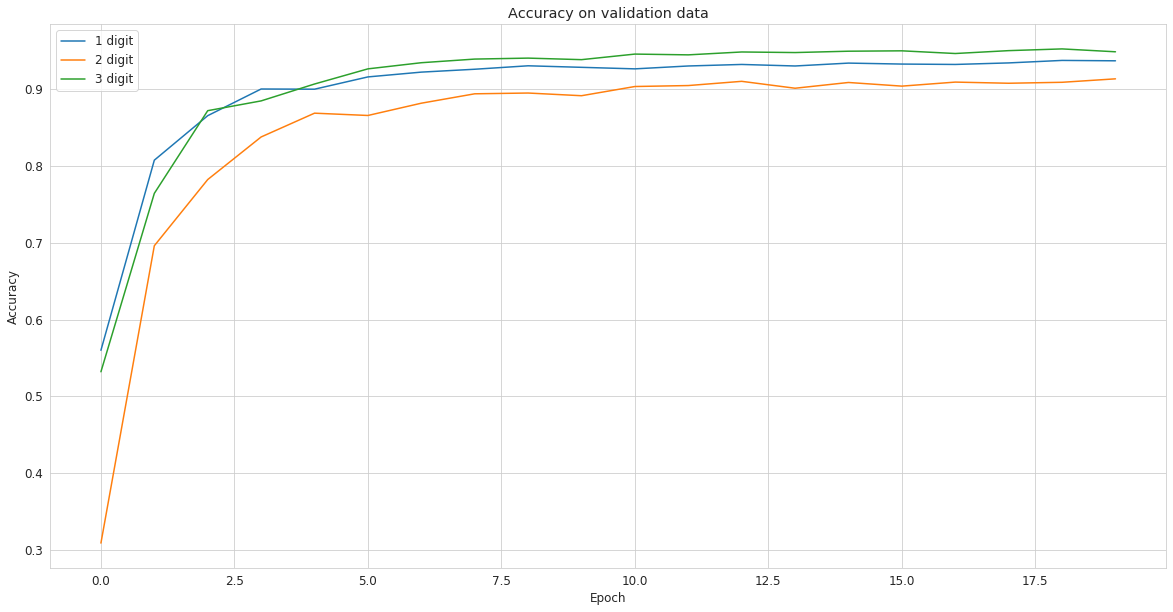

In [657]:
plt.plot(history.history['val_dense_27_acc'], label='1 digit')
plt.plot(history.history['val_dense_28_acc'], label='2 digit')
plt.plot(history.history['val_dense_29_acc'], label='3 digit')
plt.title('Accuracy on validation data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

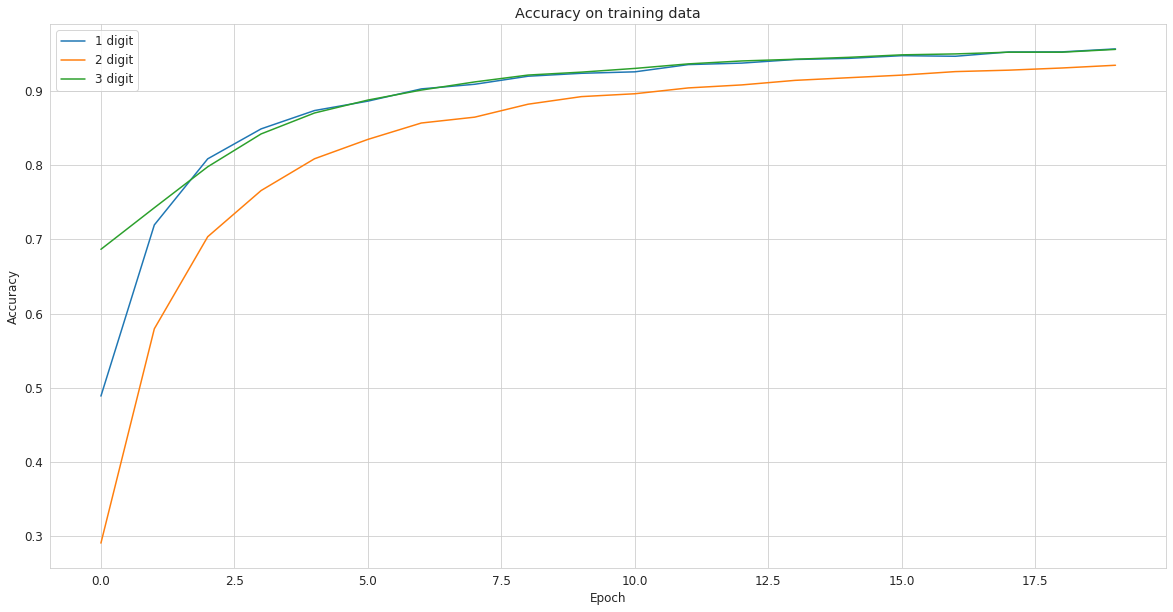

In [327]:
plt.plot(history.history['dense_17_acc'], label='1 digit')
plt.plot(history.history['dense_18_acc'], label='2 digit')
plt.plot(history.history['dense_19_acc'], label='3 digit')
plt.title('Accuracy on training data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

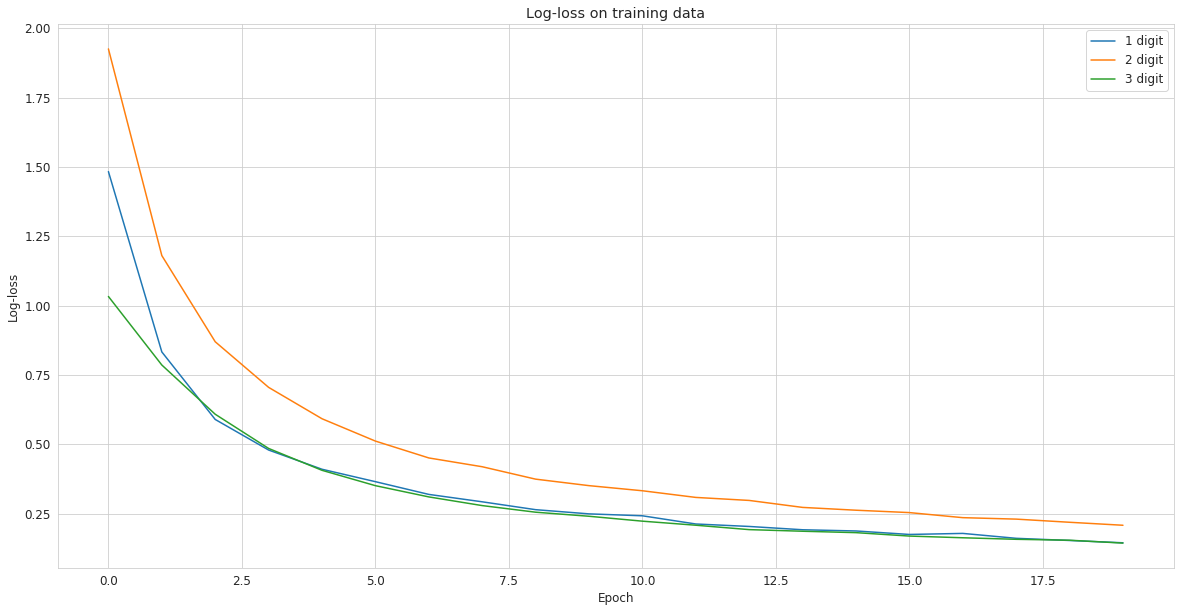

In [328]:
plt.plot(history.history['dense_17_loss'], label='1 digit')
plt.plot(history.history['dense_18_loss'], label='2 digit')
plt.plot(history.history['dense_19_loss'], label='3 digit')
plt.title('Log-loss on training data')
plt.xlabel('Epoch')
plt.ylabel('Log-loss')
plt.legend()
plt.show()

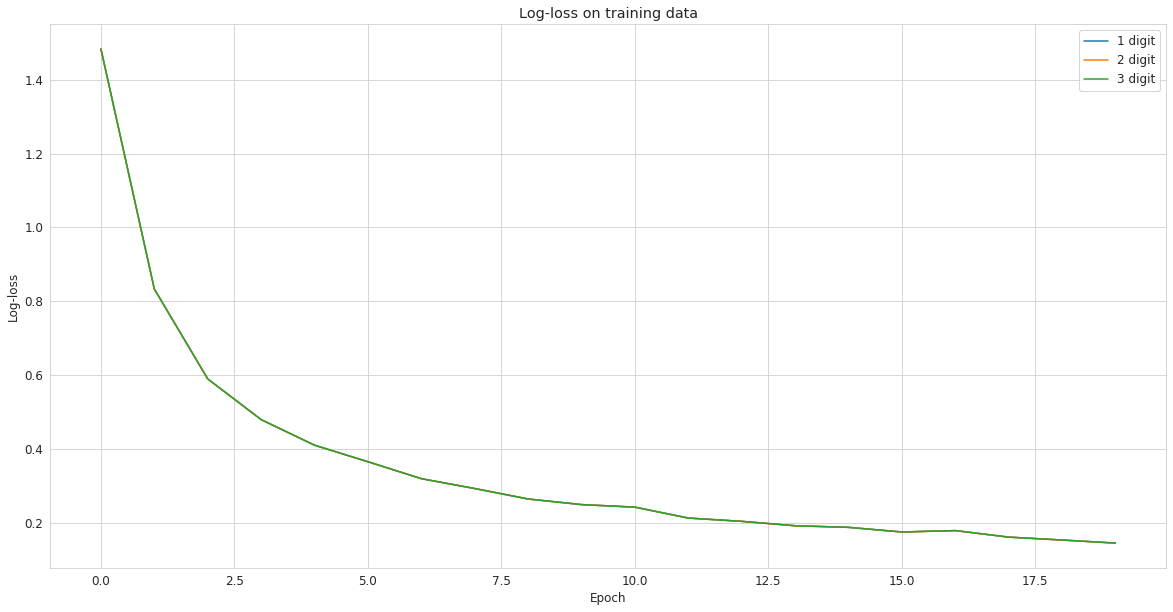

In [329]:
plt.plot(history.history['dense_17_loss'], label='1 digit')
plt.plot(history.history['dense_17_loss'], label='2 digit')
plt.plot(history.history['dense_17_loss'], label='3 digit')
plt.title('Log-loss on training data')
plt.xlabel('Epoch')
plt.ylabel('Log-loss')
plt.legend()
plt.show()

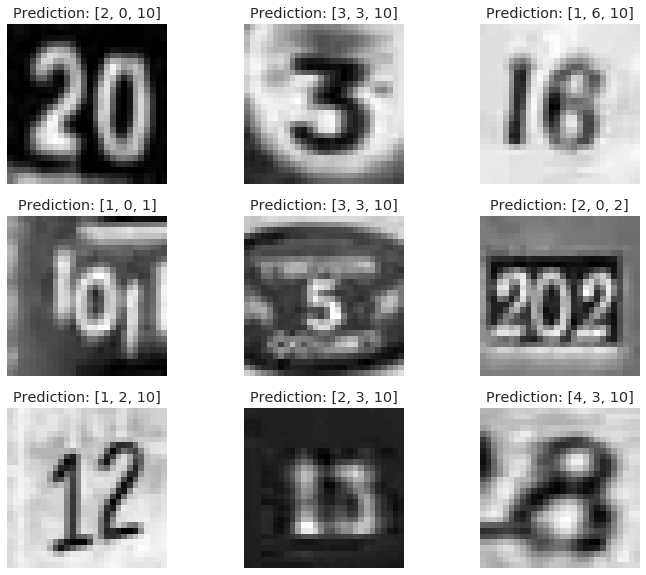

In [484]:
fig = plt.figure(figsize=(12, 10))
for i in range(1, 10):
    ax = fig.add_subplot(3, 3, i)
    test_image = random.choice(test_dataset)
    prediction = model.predict(test_image.reshape(1,RESOLUTION,RESOLUTION,1))
    ax.set_title(f"Prediction: {[np.argmax(i) for i in prediction]}")
    ax.set_axis_off()
    plt.imshow(test_image.reshape(RESOLUTION, RESOLUTION), cmap='binary')

In [485]:
def check_model(x_test_gen, model):
    fig = plt.figure(figsize=(12, 10))
    for i in range(1, 10):
        ax = fig.add_subplot(3, 3, i)
        test_image = random.choice(test_dataset)
        prediction = model.predict(test_image.reshape(1,RESOLUTION,RESOLUTION,1))
        ax.set_title(f"Prediction: {[np.argmax(i) for i in prediction]}")
        ax.set_axis_off()
        plt.imshow(test_image.reshape(RESOLUTION, RESOLUTION), cmap='binary')

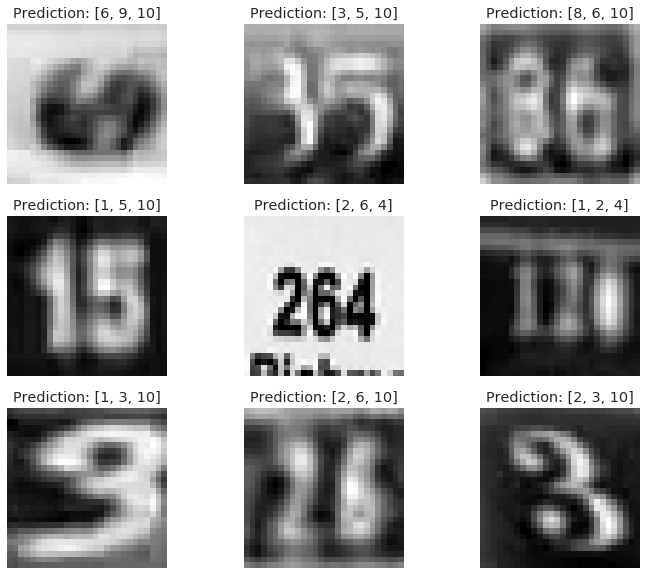

In [486]:
check_model(test_dataset, model)

In [658]:
model.evaluate(test_dataset, test_labels)

12920/12920 [==============================] - 26s 2ms/sample - loss: 4.2031 - dense_27_loss: 0.5806 - dense_28_loss: 3.4686 - dense_29_loss: 0.1535 - dense_27_acc: 0.8488 - dense_28_acc: 0.7344 - dense_29_acc: 0.9619


[4.203074165615873,
 0.5805792,
 3.468603,
 0.15349238,
 0.8487616,
 0.73436534,
 0.9619195]

In [633]:
def show_images(prefix=''):
    fig = plt.figure(figsize=(15, 15))
    for number in range(1, 13):   
        ax = fig.add_subplot(3, 4, number)
        image = Image.open(f'Images/{prefix}{number}.jpg')
        ax.set_axis_off()
        plt.imshow(image)

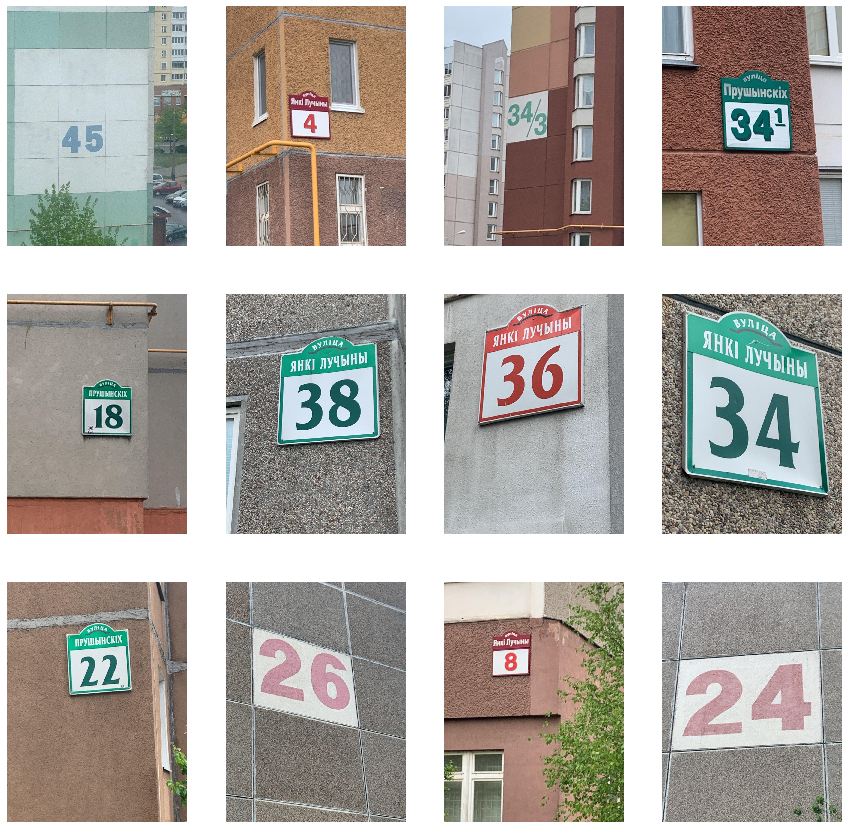

In [634]:
show_images()

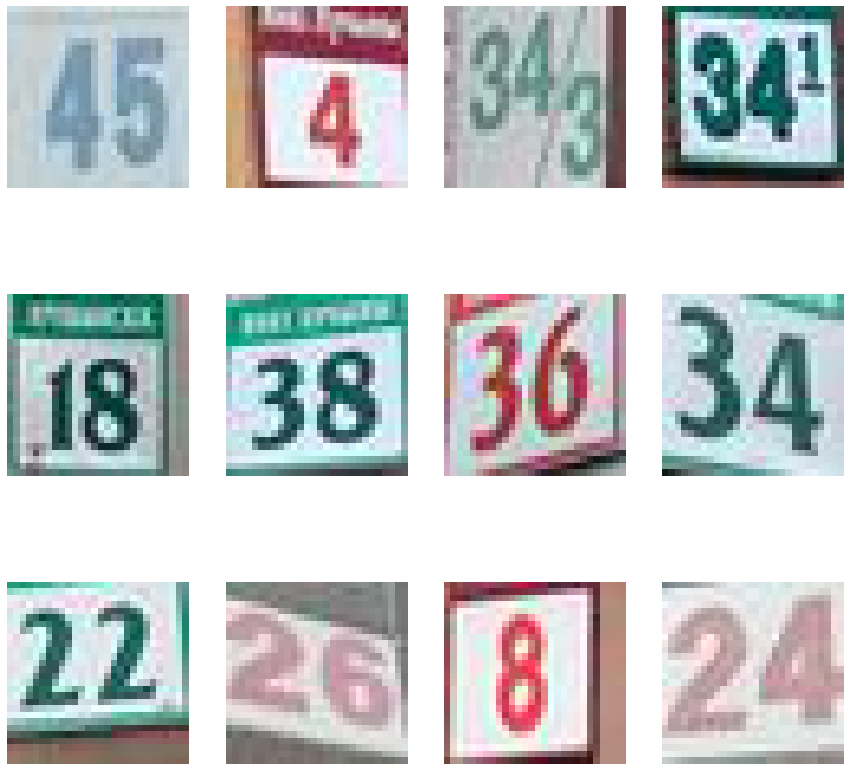

In [635]:
show_images('crop_')

In [568]:
def check_size(number, a,b,c,d):
    image = Image.open(f'Images/{number}.jpg')
    plt.imshow(image)
    plt.show()
    crop = image.crop((a, b, c, d)).resize([RESOLUTION,RESOLUTION], Image.ANTIALIAS)
    plt.imshow(crop)
    crop.save(f'Images/crop_{number}.jpg')

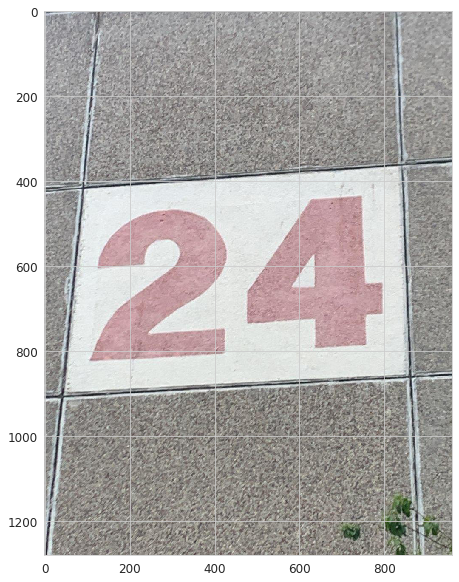

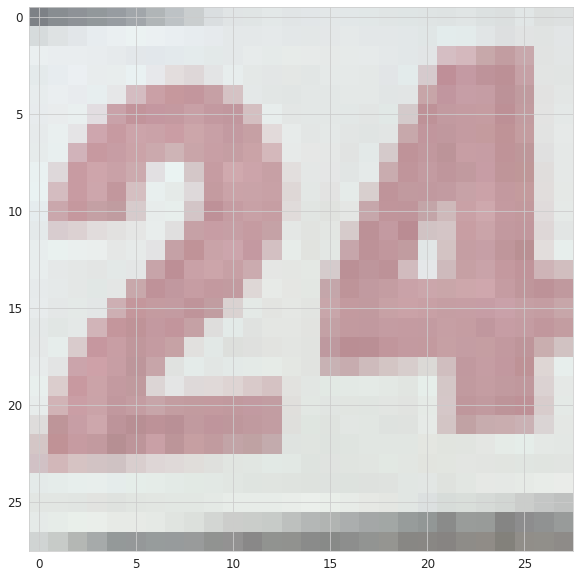

In [609]:
check_size(16, 100, 400, 800, 900)

In [639]:
def show_prediction():
    fig = plt.figure(figsize=(15, 15))
    for number in range(1, 13):   
        ax = fig.add_subplot(4, 3, number)
        ax.set_axis_off()
        image = Image.open(f'Images/crop_{number}.jpg')
        plt.imshow(image)
        image = np.dot(np.array(image, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
        image /= 255
        prediction = model.predict(image.reshape(1,RESOLUTION,RESOLUTION,1))
        ax.set_title([np.argmax(i) for i in prediction])

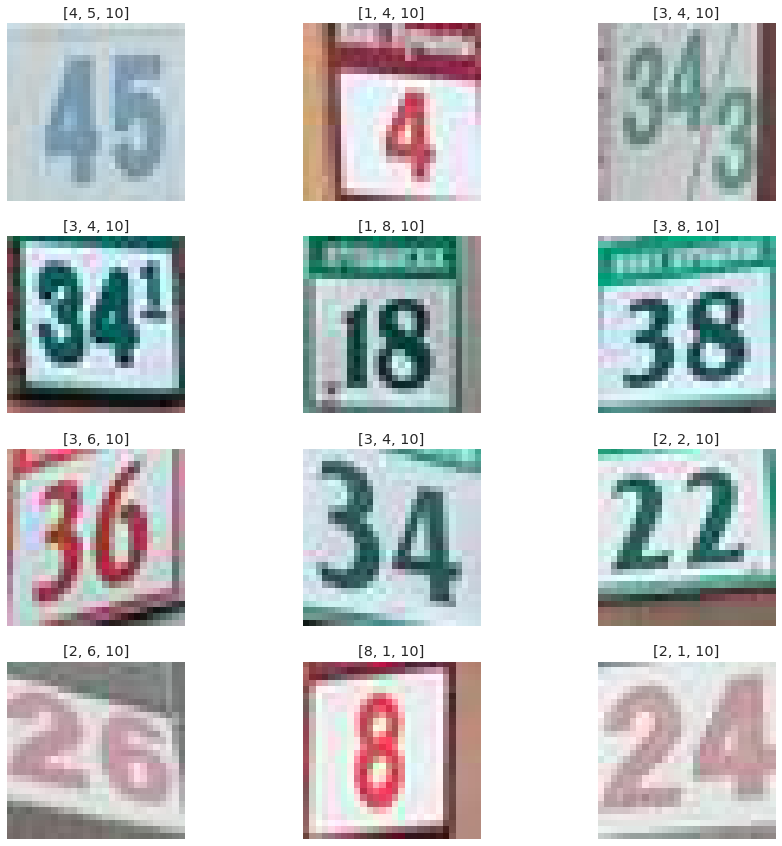

In [640]:
show_prediction()